# 딥러닝 네트워크

  - 현재 딥러닝 네트워크의 오류율은 매우 낮아졌다.
  - 이렇게 오류율을 낮출 수 있는 가장 큰 이유는 모델을 더 깊게 만들기 때문이다.
  - 과거 한자리 수 레이어에서 최근의 ResNet의 경우 152 레이어까지 늘어난 것을 알 수 있다.

## 망이 깊어지면 부작용은 없나?

  - 딥러닝 네트워크에서 망의 크기를 늘리면 성능을 더 높일 수 있다.
  - 하지만 적절하지 못하면 2가지의 중대한 문제를 만날 수 있다.
  - 첫번째는 망이 커질수록 자유 파라미터의 수가 증가하게 되는데 이렇게 되면 특히 학습에 사용할 데이터의 양이 제한적인 경우 오버피팅에 빠질 가능성이 높아진다.(즉 학습 데이터에만 특화되어 있고 실제 테스트 set에는 만족할만한 결과를 얻지 못한다)
  - 또 다른 문제는 망의 크기가 커지면 그만큼 연산량이 늘어나게 된다.

## Vanishing gradient(경사소실)

  - 네트워크를 깊게 쌓기 어려운 이유는 경사 소실에 있다.
  - 멀리서 말하는 사람의 목소리가 잘 안들리듯이 모델이 깊어질수록 모델의 학습을 위한 Gradient가 사라지는 현상이 발생한다.
  - 이렇게 Gradient가 매우 작아져서 레이어를 학습시키기 위해 충분한 값을 표현하지 못하는 경우를 기울기 소실(경사소실)이라고 한다.
  - Vanishing 혹은 Exploding Gradient의 문제가 발생하는 원인은 레이어가 깊어지면서 Gradient가 매우 커지거나 작아지기 때문이다.
  - 레이어의 가중치가 반복되서 곱해지면 1보다 작은 경우에는 0에 너무 가까워져버리고 1보다 큰 경우에는 기하급수적으로 커지기 때문이다.
  - 이런 Vanishing Gradient 문제를 해결하기 위해서 가중치를 초기화해서 문제를 해결할 수 있다.

## ResNet

  - ResNet은 vanishing/exploding gradient의 문제를 해결하기 위해서 생각보다 간단한 방법을 사용하였다.

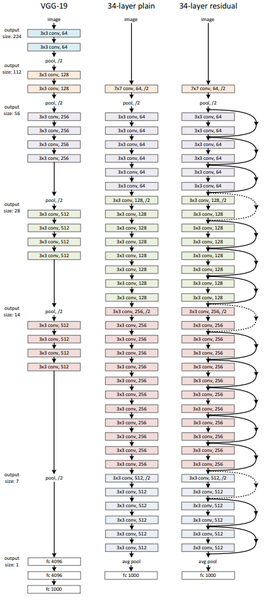
  - 출처 : lms aiffel 노드

  - 왼쪽의 VGG19와 ResNet34를 비교해보면 ResNet34가 확연히 레이어의 수가 더 많은 것을 확인할 수 있다.
  - 또 가운데의 plain ResNet과 우측의 Residual ResNet을 비교해보면 Residual ResNet은 skip connection이라는 구조를 사용해서 경사 소실 문제를 해결하였다.

## Skip Connection

  - skip connection은 레이어의 입력을 다른 곳에 이어서 gradient가 깊은 곳까지 이어지게 하는 것이다.

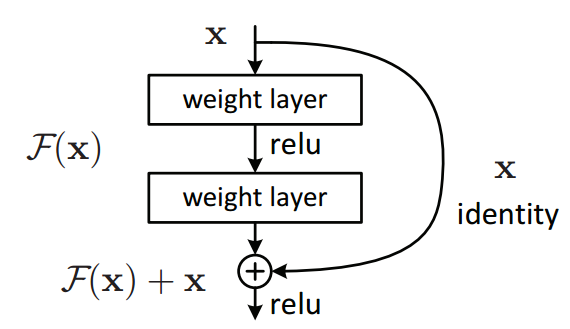

  - 출처 : lms aiffel 노드

# 코드 실습

  - 기존의 이미지 분류기를 더 깊게 설계된 딥러닝 모델인 VGG16하고 ResNet-50으로 바꿔보는 과정을 진행해본다.

In [1]:
# 기존의 이미지 분류기

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# CIFAR100 데이터셋을 가져옵시다. 
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

x_train: 50000 x_test: 10000


In [2]:
img_input = keras.Input(shape=(32, 32, 3))

x = keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
predictions = keras.layers.Dense(100, activation='softmax')(x)

model = keras.Model(inputs=img_input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               295168

  - 기존의 이미지 분류기인 CNN은 대략 학습해야 할 파라미터가 32만6천개정도 된다.

In [3]:
# 모델 학습!! 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)    # 1 Epoch만 학습합니다.

1563/1563 [==============================] - 7s 3ms/step - loss: 3.6380 - accuracy: 0.1552


### 기존의 CNN 모델에서 VGG16 모델로 바꿔보기

  - 각 코드 Block마다 어떻게 구현되어 있는지 찾아야 한다.
  - 코드는 Keras VGG16 코드구현 링크인 https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py 여기서 찾을 수 있다.

In [4]:
# 첫번째 블록(첫번째 max pooling까지)

x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(img_input)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

print('첫 번째 블록 OK!!')

첫 번째 블록 OK!!


In [5]:
# 두번째 블록(두번째 max poolinig까지)

x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)


print('두 번째 블록 OK!!')

두 번째 블록 OK!!


In [6]:
# 세번째 블록(세번째 max pooling까지)

x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)


print('세 번째 블록 OK!!')

세 번째 블록 OK!!


In [7]:
# 네번째 블록(네번째 max pooliing까지)

x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

print('네 번째 블록 OK!!')

네 번째 블록 OK!!


In [8]:
# 다섯번째 블록(다섯번째 max pooling까지)

x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

print('다섯 번째 블록 OK!!')

다섯 번째 블록 OK!!


In [9]:
# 여섯번째 블록(완전 연결 계층 + softmax까지)
# [Keras VGG16 코드 구현] 링크의 if include_top: 부분을 유심히 보세요 

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)

print('여섯 번째 블록 OK!!')

classes=100
x = layers.Dense(classes, activation='softmax', name='predictions')(x)    # CIFAR100을 위한 모델 Output

여섯 번째 블록 OK!!


In [10]:
model = keras.Model(name="VGG-16", inputs=img_input, outputs=x)

model.summary()

Model: "VGG-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0    

  - 쌓은 레이어들을 통해 만들언진 VGG16 모델의 학습 파라미터는 약 3천4백만개나 된다.
  - 앞서 기존의 모델이었던 CNN 모델보다 약 100배 많아진 수치이다.

In [11]:
# 모델 학습!! 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)    # 1 Epoch만 학습합니다.

1563/1563 [==============================] - 46s 29ms/step - loss: 4.6061 - accuracy: 0.0086


  - 파라미터가 34M이나 되는 VGG16은 이미지넷 데이터를 토대로 수 시간 동안 학습을 진행해야 안정적으로 결과를 낼 수 있다.

### Skip connection이 추가되어 있는 ResNet-50

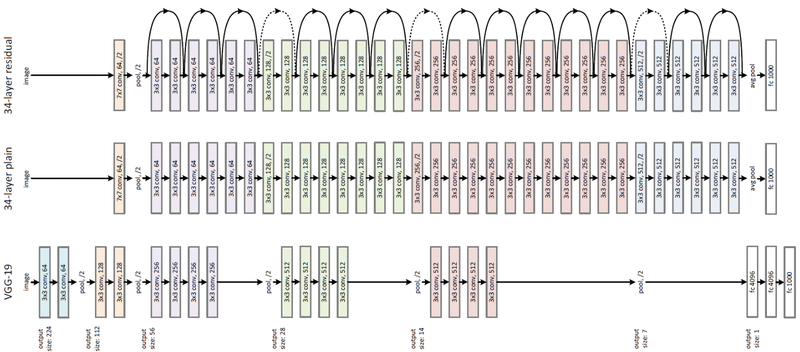
  - 출처 : lms aiffel 노드

  - 위의 그림에서 보면 알 수 있듯이 ResNet은 skip connection을 포함한 Residual Block로 구성되어 있다.
  - ResNet-50은 모델에 반복적으로 활용하는 conv_block와 identity_block가 있다.
  - 이런 블록 구조를 잘 활용하여 50개나 되는 복잡한 레이어 구조를 간결하게 표현할 수 있다.
  - ResNet-50 구성 코드는 Keras ResNet50 코드 구현 링크인 https://git.dst.etit.tu-chemnitz.de/external/tf-models/-/blob/1d057dfc32f515a63ab1e23fd72052ab2a954952/official/vision/image_classification/resnet_model.py 에서 확인할 수 있다.

In [20]:
# 필요한 라이브러리 import

from tensorflow.keras import backend, regularizers, initializers, models

# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

print('Resnet50 GoGo!!')

Resnet50 GoGo!!


In [21]:
# conv_block 생성

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2),
               use_l2_regularizer=True,
               batch_norm_decay=0.9,
               batch_norm_epsilon=1e-5):
  """A block that has a conv layer at shortcut.
  Note that from stage 3,
  the second conv layer at main path is with strides=(2, 2)
  And the shortcut should have strides=(2, 2) as well
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    strides: Strides for the second conv layer in the block.
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      strides=strides,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  shortcut = layers.Conv2D(
      filters3, (1, 1),
      strides=strides,
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '1')(
          input_tensor)
  shortcut = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '1')(
          shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

In [22]:
# identity_block 생성

def identity_block(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):
  """The identity block is the block that has no conv layer at shortcut.
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)
  return x

In [23]:
# ResNet-50 모델 생성

def resnet50(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):
  """Instantiates the ResNet50 architecture.
  Args:
    num_classes: `int` number of classes for image classification.
    batch_size: Size of the batches for each step.
    use_l2_regularizer: whether to use L2 regularizer on Conv/Dense layer.
    rescale_inputs: whether to rescale inputs from 0 to 1.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
      A Keras model instance.
  """

  input_shape = (32, 32, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)
  if rescale_inputs:
    # Hub image modules expect inputs in the range [0, 1]. This rescales these
    # inputs to the range expected by the trained model.
    x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(
            imagenet_preprocessing.CHANNEL_MEANS,
            shape=[1, 1, 3],
            dtype=x.dtype),
        name='rescale')(
            img_input)
  else:
    x = img_input

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(x)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_block(
      x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

  x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

  x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

  x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet50')

In [24]:
model = resnet50(num_classes=100)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

  - VGG16 모델과 비교했을 때 레이어의 수는 더 많아졌지만 학습 파라미터의 수는 오히려 10M 정도 작아졌다.

In [25]:
# 모델 학습!! 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)    # 1 Epoch만 학습합니다.

1563/1563 [==============================] - 69s 41ms/step - loss: 8.2839 - accuracy: 0.0644


  - 위의 ResNet-50에서 skip connection이 구현되어 있는 부분은 다음과 같다.
  - conv_block 내에서 구현 / x = layers.add([x, shortcut])
  - identity_block 내에서 구현 / x = layers.add([x, input_tensor])